--Download library--

In [4]:
!pip install corextopic
!pip install gensim
!pip install spacy
!pip install yellowbrick

# # Import Dependencies

In [5]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Setup NLP Pipeline and Data Cleaning 

In [6]:
##define nlp and start cleaning data
nlp= spacy.load("en")

# List of stop words to equalize data
stop_list = ["Depression","depression"]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [7]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

## Import data, create a list of lists and push through NLP pipeline

In [8]:
doc_dep = pd.read_csv(r'Datasets/2020_March_r_Depression.csv')
doc_dep = doc_dep[doc_dep.Body != '[removed]']


In [9]:
#create a list of documents (list of lists) 
text_doc = doc_dep['Body'].tolist()

In [10]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [11]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)
    
df_doc_dep = pd.DataFrame(empt,columns = ['Body'])
#df_doc_dep is a dataframe that has cleaned posts from Depression subreddit.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)


df_doc_dep['label'] = 0

In [12]:
df_doc_dep

,Body,label
0,Uk cahms service shit sure schizophrenia fucki...,0
1,anybody luck holistic treatment gut health met...,0
2,leave bed 4:20pm work 5:00pm feel like walk dr...,0
3,want help people care feel right like wrong bo...,0
4,obviously want unhappy want depressed miserabl...,0
...,...,...
17546,finally open therapist feel happen pandemic st...,0
17547,need work day hate work hate wake early hate c...,0
17548,THEORY MASKS \n\n think visualize mask Mask p...,0
17549,lose pretty cry sorry mom dad longer second pa...,0


## Vectorize words with TFIDF

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.2,
    min_df=8,
    max_features=None,
    ngram_range=(1, 1),
    norm=None,
    binary=True,
    use_idf=True,
    sublinear_tf=False
)

vectorizer = vectorizer.fit(df_doc_dep.Body)
tfidf = vectorizer.transform(df_doc_dep.Body)
vocab = vectorizer.get_feature_names()
print(len(vocab))

5580


## Get top 50 tokens 

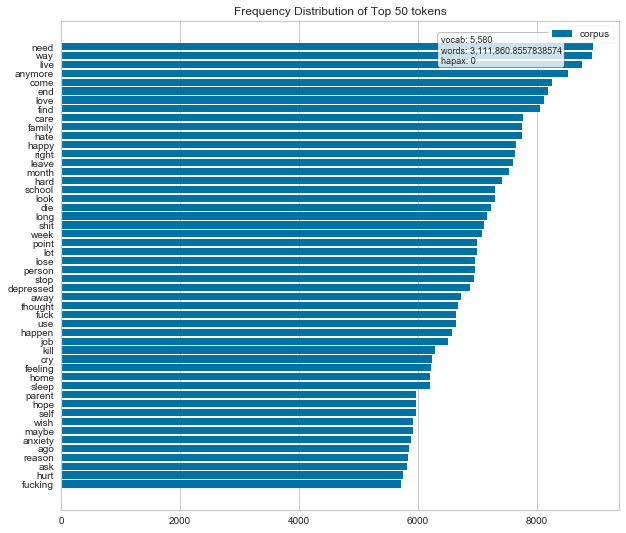

In [162]:
fig, ax = plt.subplots(figsize=(10,9))
docs = vectorizer.fit_transform(df_doc_dep.Body)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## LDA Topic Modeling Semi-Supervised w/CorexTopic

In [ ]:
#df_tf = pd.DataFrame(columns = ['word','tf-idf'])
#for k in range (tfidf.shape[0]):
    #feature_index = tfidf[k,:].nonzero()[1]
    #tfidf_scores = zip([vocab[i] for i in feature_index], [tfidf[0, x] for x in feature_index])
    #df_temp = pd.DataFrame(tfidf_scores, columns = ['word','tf-idf'])
    #df_tf.append(df_temp)
    

In [ ]:
#feature_index = tfidf[0,:].nonzero()[1]
#feature_index

In [62]:
#import corextopic

from corextopic import corextopic as ct
anchors = []
model = ct.Corex(n_hidden=6, seed=42)
model = model.fit(
    tfidf,
    words=vocab
)

In [151]:
alist=[];
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: month ,mental ,lot ,week ,health ,anxiety ,issue ,read ,post ,thank ,past ,struggle ,able ,experience ,change
Topic #2: job ,school ,home ,find ,college ,money ,high ,old ,pay ,new ,lose ,social ,house ,spend ,graduate
Topic #3: come ,need ,long ,end ,ago ,away ,hard ,point ,let ,right ,ask ,break ,hour ,little ,problem
Topic #4: person ,use ,feeling ,relationship ,happy ,happen ,mind ,self ,cry ,maybe ,thought ,girl ,head ,wrong ,meet
Topic #5: live ,family ,love ,way ,leave ,care ,parent ,mom ,dad ,die ,mother ,shit ,hate ,kid ,anymore
Topic #6: look ,face ,walk ,big ,later ,play ,hear ,hand ,sit ,real ,body ,hold ,small ,hit ,run


In [152]:
alist

[['month mental lot week health anxiety issue read post thank past struggle able experience change'],
 ['job school home find college money high old pay new lose social house spend graduate'],
 ['come need long end ago away hard point let right ask break hour little problem'],
 ['person use feeling relationship happy happen mind self cry maybe thought girl head wrong meet'],
 ['live family love way leave care parent mom dad die mother shit hate kid anymore'],
 ['look face walk big later play hear hand sit real body hold small hit run']]

In [54]:
topic_red_df = pd.DataFrame(alist, columns =list(np.arange(1,16)))
topic_red_df['label']= list(topic_red_df.index)
topic_red_df.label +=1
topic_red_df[list(np.arange(1,16))]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,month,mental,lot,week,health,anxiety,issue,read,post,thank,past,struggle,able,experience,change
1,job,school,home,find,college,money,high,old,pay,new,lose,social,house,spend,graduate
2,come,need,long,end,ago,away,hard,point,let,right,ask,break,hour,little,problem
3,person,use,feeling,relationship,happy,happen,mind,self,cry,maybe,thought,girl,head,wrong,meet
4,live,family,love,way,leave,care,parent,mom,dad,die,mother,shit,hate,kid,anymore
5,look,face,walk,big,later,play,hear,hand,sit,real,body,hold,small,hit,run


0    [month, mental, lot, week, health, anxiety, is...
1    [job, school, home, find, college, money, high...
2    [come, need, long, end, ago, away, hard, point...
3    [person, use, feeling, relationship, happy, ha...
4    [live, family, love, way, leave, care, parent,...
5    [look, face, walk, big, later, play, hear, han...
Name: 0, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

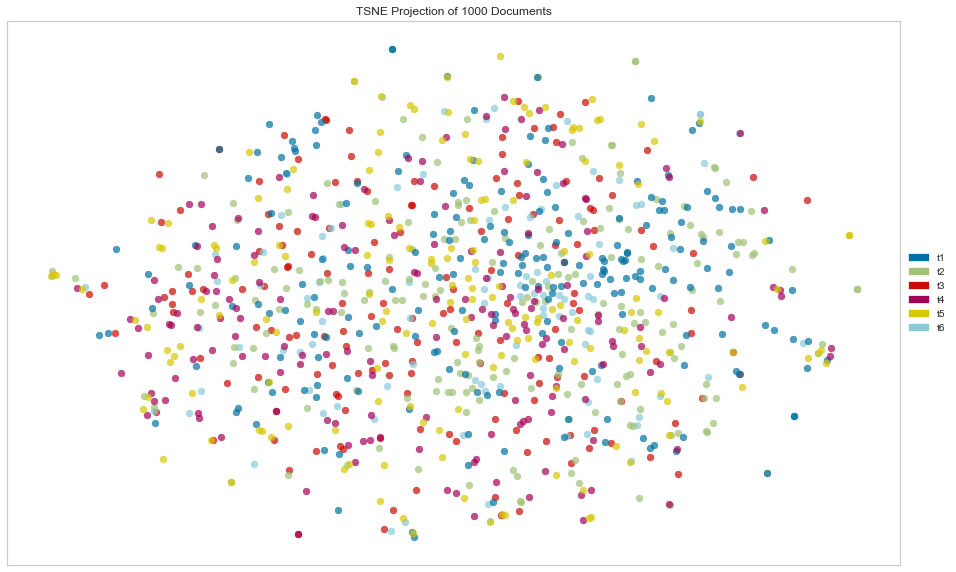

In [164]:
# from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = new_corpus1.Body

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = new_corpus1.label

# Create the visualizer and draw the vectors
fig, ax = plt.subplots(figsize=(20,10))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()


In [154]:
tsne.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.2,
    min_df=8,
    max_features=None,
    ngram_range=(1, 1),
    norm=None,
    binary=True,
    use_idf=True,
    sublinear_tf=False
)

vectorizer = vectorizer.fit(df_doc_dep.Body)
tfidf = vectorizer.transform(df_doc_dep.Body)
vocab = vectorizer.get_feature_names()
print(len(vocab))

In [133]:
# Print a single topic from CorEx topic model
model.get_topics(topic=1, n_words=60)



[('job', 0.12082770434842358),
 ('school', 0.08021833943287571),
 ('home', 0.06801963181631462),
 ('find', 0.05658837512006076),
 ('college', 0.05619065640572618),
 ('money', 0.05525838050094904),
 ('high', 0.05146198901235394),
 ('old', 0.04774064832533781),
 ('pay', 0.046786500282206836),
 ('new', 0.044772123575143846),
 ('lose', 0.043100968269912054),
 ('social', 0.03781737785829528),
 ('house', 0.03688005454027268),
 ('spend', 0.03678955554728042),
 ('graduate', 0.030206295074539955),
 ('study', 0.027430409639947164),
 ('game', 0.02560315413182974),
 ('great', 0.024712831527977288),
 ('university', 0.02464230056133024),
 ('car', 0.024092120915239042),
 ('plan', 0.023939307425924105),
 ('future', 0.023523509491586696),
 ('learn', 0.023214947168122748),
 ('idea', 0.023171774856234475),
 ('stress', 0.023035660337852506),
 ('student', 0.022299277576892065),
 ('country', 0.02223057304824236),
 ('finish', 0.022184270251571016),
 ('fail', 0.02146714364528977),
 ('drive', 0.021451076109384

The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from get_topics(), then the absolute value of that quantity is the mutual information between the topic and the absence of that word.

In [59]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

NameError: name 'topic_model' is not defined

In [109]:
import random
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["t{}".format(i+1) for i in range(6)]
).astype(float)
topic_df.astype(int)
a1=[];
for i in range(topic_df.shape[0]):
    a2 = list(topic_df.iloc[i][topic_df.iloc[i]==1].index)
    random.shuffle(a2)
    a1.append(a2)
    
topic_df['label'] = a1


In [110]:
a2 = [topic_df.label[i] != [] for i in range(topic_df.shape[0])]
topic_df = topic_df[a2]

In [106]:
a3

In [155]:
topic_df['new_label'] = [topic_df['label'].iloc[i][0] for i in range(topic_df.shape[0])]

In [156]:
new_corpus = df_doc_dep.iloc[topic_df.index]
new_corpus.label =  topic_df['new_label']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [160]:
new_corpus1 = new_corpus.sample(n=1000)
new_corpus1

,Body,label
2848,know ppl use March fifth year clean thing lot ...,t3
15131,ex boyfriend pretend date 8 year fake marriage...,t6
6420,feel like sad excuse person hope young friend ...,t2
3298,hello people subreddit struggle year recently ...,t1
7670,hate talk mental health sound normal immediate...,t1
...,...,...
9815,hello guy post \n\n context 17 year old guy b...,t2
2037,hi work healthcare anxiety feel like feeling b...,t2
883,regular medication add mood stabilizer couple ...,t1
8868,feel like truly care anymore people rarely ask...,t4


In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);



In [ ]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    ["girl"],
    ["family"],
    ["home"],
    ["school"],
    ["mental"],
    ["suicide"],

]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=6, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=1 # Tell the model how much it should rely on the anchors
)

In [ ]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

In [ ]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range(6)]).astype(float)
topic_df.iloc[0:10]

In [ ]:
from corextopic import vis_topic as vt
vt.vis_rep(model, column_label=words, prefix='topic-model-example')

## LDA Unsupervised

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

In [ ]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=6, 
                                           random_state=2,
                                           update_every=1,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
#print the keyword in the 6 topics
pprint(lda_model.print_topics(num_words=100))

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

In [ ]:
df_dominant_topic.head(25)
#df_dominant_topic.to_csv(r'depression_2020_datest.csv')

In [ ]:
from collections import Counter
Counter(df_dominant_topic.Dominant_Topic)

# # Obtain TFIDF weights for salient words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus.data)
y = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [ ]:
plt.show(tsne)

In [ ]:
import matplotlib
matplotlib.use('TkAgg')